# **Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
import joblib

# **Dataset**

### Downloading Dataset From Kaggle

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download WESAD dataset
!kaggle datasets download -d mohamedasem318/wesad-full-dataset
!unzip wesad-full-dataset.zip -d wesad_data

#Check
subject_folders = [f for f in os.listdir('wesad_data/WESAD') if f.startswith('S') and f not in ['S1', 'S12']]
print(f"Total subjects available: {len(subject_folders)}")

Reconnecting to Drive

In [ ]:
from google.colab import files

### **Data Loading**

Fixed Windowing, Overlapping, ECG Freq. Sampling

In [ ]:
FS = 700  # sampling frequency
WINDOW_SIZE = 300  # seconds == 5 min
OVERLAP = 0.5  # 50%

Data Reading

In [ ]:
subject_ids = [f'S{i}' for i in range(2,18) if i != 12] # subjects ids
ecg_data = []
labels = []
subject_info = []

for subject in subject_ids:
    with open(f'wesad_data/WESAD/{subject}/{subject}.pkl', 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    ecg_data.append(data['signal']['chest']['ECG']) # ECG signal only
    labels.append(np.where(data['label'] == 2, 1, 0)) # stress = 1, not stressed = 0

    # for visualization
    subject_info.append({
        'subject': subject,
        'minutes': len(data['signal']['chest']['ECG']) / FS / 60
    })

ecg_all = np.concatenate(ecg_data)
labels_all = np.concatenate(labels)

print(f"Successfully loaded {len(subject_ids)} subjects")
print(f"Total ECG samples: {len(ecg_all)}")

Successfully loaded 15 subjects
Total ECG samples: 60807600


# **Data Visualization**

ECG Length Bars

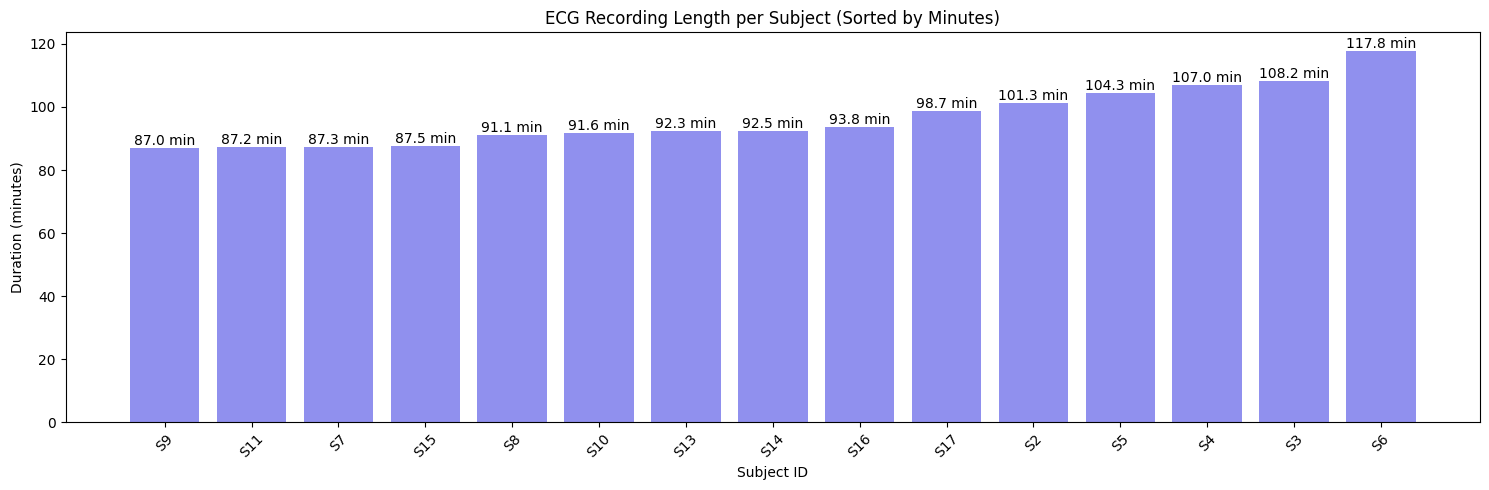

In [ ]:
stress_stats = {
    'stressed': np.sum(labels_all == 1),
    'not_stressed': np.sum(labels_all == 0)
}

df_lengths = pd.DataFrame([{
    'subject': info['subject'],
    'minutes': round(info['minutes'], 1)
} for info in subject_info]).sort_values('minutes')


plt.figure(figsize=(15, 5))
bars = plt.bar(df_lengths['subject'], df_lengths['minutes'], color='#9090ee')
plt.title('ECG Recording Length per Subject (Sorted by Minutes)')
plt.ylabel('Duration (minutes)')
plt.xlabel('Subject ID')
for bar in bars: # Add value labels on top of bars
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height} min', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_minutes = df_lengths['minutes'].sum()
print(f"Total recording time across all subjects: {total_minutes:.1f} minutes")

Stress Distribution Pie Chart

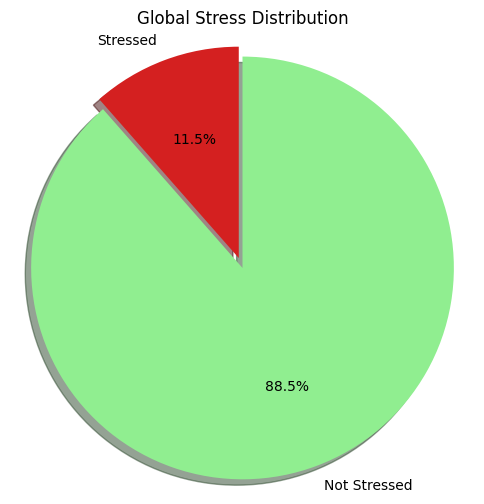


Total Subjects: 15
Total ECG Samples: 60,807,600
Stressed Samples: 6,976,201 (11.5%)
Non-Stressed Samples: 53,831,399 (88.5%)


In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    [stress_stats['stressed'], stress_stats['not_stressed']],
    labels=['Stressed', 'Not Stressed'],
    colors=['#d42020', '#90ee90'],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0),
    shadow=True
)
plt.title('Global Stress Distribution')
plt.axis('equal')
plt.show()

total_samples = len(labels_all)
print(f"\nTotal Subjects: {len(subject_ids)}")
print(f"Total ECG Samples: {total_samples:,}")
print(f"Stressed Samples: {stress_stats['stressed']:,} ({stress_stats['stressed']/total_samples*100:.1f}%)")
print(f"Non-Stressed Samples: {stress_stats['not_stressed']:,} ({stress_stats['not_stressed']/total_samples*100:.1f}%)")

# **Preprocessing**

Windowing & Features Extraction

In [ ]:
window_samples = WINDOW_SIZE * FS
step = int(window_samples * (1 - OVERLAP))

features = []
window_labels = []

for i in range(0, len(ecg_all) - window_samples, step):
    segment = ecg_all[i:i+window_samples]
    segment = segment.flatten()
    label = int(np.mean(labels_all[i:i+window_samples]) > 0.5)  # by majority

    features.append({
        'mean': np.nanmean(segment),
        'std': np.nanstd(segment),
        'min': np.nanmin(segment),
        'max': np.nanmax(segment),
        'skew': stats.skew(segment) if np.std(segment) > 1e-6 else 0,
        'kurtosis': stats.kurtosis(segment) if np.std(segment) > 1e-6 else 0
        })
    window_labels.append(label)

X = pd.DataFrame(features)
y = np.array(window_labels)

print(f"Successfully created {len(features):,} windows")
print(X.describe().round(4))

Successfully created 578 windows
           mean       std       min       max      skew  kurtosis
count  578.0000  578.0000  578.0000  578.0000  578.0000  578.0000
mean     0.0011    0.2620   -0.8035    1.4553    3.1217   15.4550
std      0.0003    0.0598    0.2990    0.1356    1.1835    5.4966
min     -0.0003    0.1120   -1.5000    0.7974   -0.4736    4.1327
25%      0.0009    0.2332   -1.0165    1.4992    2.4639   11.5870
50%      0.0011    0.2662   -0.7266    1.4995    3.4170   15.1003
75%      0.0013    0.2982   -0.5669    1.4995    3.9290   19.1709
max      0.0018    0.4512   -0.2813    1.5000    5.2256   29.7255


Cleaning & Normalization

In [ ]:
# cleaning
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# normalizing
X_normalized = StandardScaler().fit_transform(X)

print("completed")

completed


# **Models**

Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

## **XGB**

Training

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:23:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Testing

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.9224137931034483
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        99
           1       0.83      0.59      0.69        17

    accuracy                           0.92       116
   macro avg       0.88      0.78      0.82       116
weighted avg       0.92      0.92      0.92       116



## **BAG**

Training

In [ ]:
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=42)
bag_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=50, random_state=42)

Testing

In [ ]:
y_pred_bag = bag_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_bag))
print(classification_report(y_test, y_pred_bag))

Accuracy: 0.8879310344827587
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        99
           1       0.83      0.29      0.43        17

    accuracy                           0.89       116
   macro avg       0.86      0.64      0.69       116
weighted avg       0.88      0.89      0.86       116



## **Confusion Matrix**

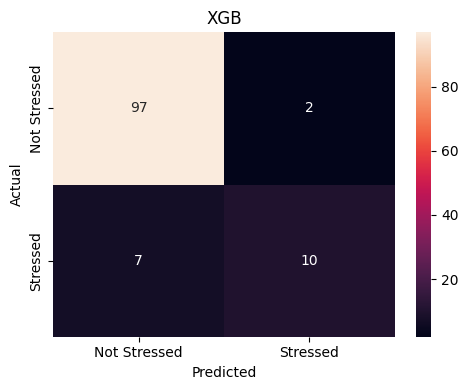

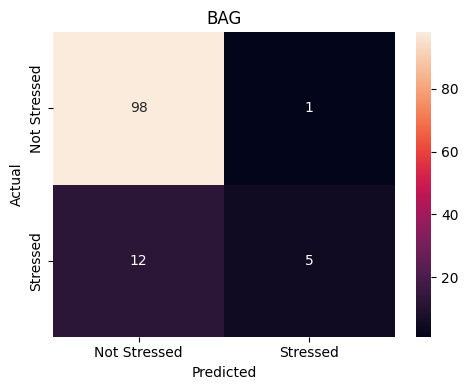

In [ ]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred_xgb, "XGB")
plot_conf_matrix(y_test, y_pred_bag, "BAG")

## **Cross Validation**

In [ ]:
scores_xgb = cross_val_score(xgb_model, X_normalized, y, cv=5, scoring='accuracy')
scores_bag = cross_val_score(bag_model, X_normalized, y, cv=5, scoring='accuracy')

print(f"XGBoost CV Accuracy: {scores_xgb.mean():.4f} ± {scores_xgb.std():.4f}")
print(f"Bagging CV Accuracy: {scores_bag.mean():.4f} ± {scores_bag.std():.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost CV Accuracy: 0.8045 ± 0.0936
Bagging CV Accuracy: 0.8529 ± 0.0576


## **Saving Models**

In [ ]:
xgb_model.fit(X_normalized, y)
bag_model.fit(X_normalized, y)

joblib.dump(xgb_model, 'final_xgb_model.joblib')
joblib.dump(bag_model, 'final_bag_model.joblib')

print("تم بحمد الله")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


تم بحمد الله
